In [48]:
from six.moves import xrange
import tensorflow as tf


def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.
    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)
    """

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            zero = tf.zeros([], dtype='int32')
            max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
            max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

            # scale indices from [-1, 1] to [0, width/height]
            x = (x + 1.0)*(width_f) / 2.0
            y = (y + 1.0)*(height_f) / 2.0


            # do sampling
            x0 = tf.cast(tf.floor(x), 'int32')
            x1 = x0 + 1
            y0 = tf.cast(tf.floor(y), 'int32')
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, zero, max_x)
            x1 = tf.clip_by_value(x1, zero, max_x)
            y0 = tf.clip_by_value(y0, zero, max_y)
            y1 = tf.clip_by_value(y1, zero, max_y)
            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.stack([-1, channels]))
            im_flat = tf.cast(im_flat, 'float32')
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            x0_f = tf.cast(x0, 'float32')
            x1_f = tf.cast(x1, 'float32')
            y0_f = tf.cast(y0, 'float32')
            y1_f = tf.cast(y1, 'float32')
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            output = tf.cast(output > 0, output.dtype) * output # assign negative values to zero
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.stack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat(axis=0, values=[x_t_flat, y_t_flat, ones])
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.stack([num_batch]))
            grid = tf.reshape(grid, tf.stack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)

            output = tf.reshape(
                input_transformed, tf.stack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output


def batch_transformer(U, thetas, out_size, name='BatchSpatialTransformer'):
    """Batch Spatial Transformer Layer
    Parameters
    ----------
    U : float
        tensor of inputs [num_batch,height,width,num_channels]
    thetas : float
        a set of transformations for each input [num_batch,num_transforms,6]
    out_size : int
        the size of the output [out_height,out_width]
    Returns: float
        Tensor of size [num_batch*num_transforms,out_height,out_width,num_channels]
    """
    with tf.variable_scope(name):
        num_batch, num_transforms = map(int, thetas.get_shape().as_list()[:2])
        indices = [[i]*num_transforms for i in xrange(num_batch)]
        input_repeated = tf.gather(U, tf.reshape(indices, [-1]))
        return transformer(input_repeated, thetas, out_size)

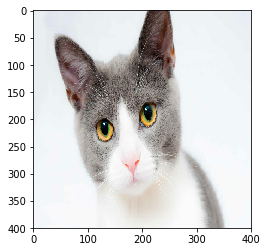

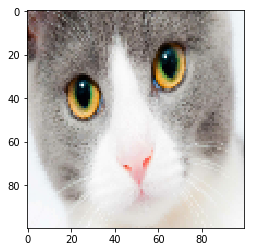

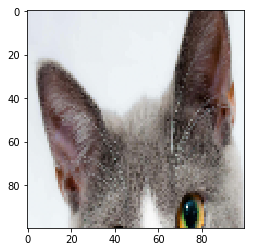

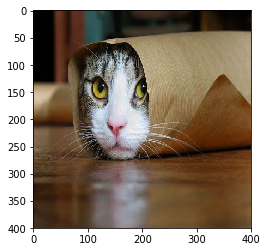

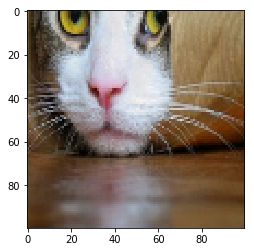

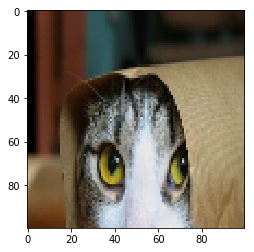

In [52]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


DIMS = [400, 400, 3]
out_size = [100, 100]
num_txf = 2

filename='./cnn_txf_data/cat1.jpg'
with tf.gfile.FastGFile(filename, 'rb') as f:
    image_data1 = f.read()
filename='./cnn_txf_data/cat2.jpg'
with tf.gfile.FastGFile(filename, 'rb') as f:
    image_data2 = f.read()
    
jpeg_image1 = tf.image.decode_jpeg(image_data1, channels=DIMS[2])
jpeg_image1 = tf.image.resize_images(jpeg_image1, [DIMS[0], DIMS[1]])
jpeg_image2 = tf.image.decode_jpeg(image_data2, channels=DIMS[2])
jpeg_image2 = tf.image.resize_images(jpeg_image2, [DIMS[0], DIMS[1]])
image1 = tf.cast(jpeg_image1, tf.float32) / 255.
image2 = tf.cast(jpeg_image2, tf.float32) / 255.
image1 = tf.reshape(image1, [DIMS[0], DIMS[1], DIMS[2]])
image2 = tf.reshape(image2, [DIMS[0], DIMS[1], DIMS[2]])
U = tf.stack([image1, image2], axis=0)
# print(U.shape) # input_tensor

txf1 = np.array([[0.5, 0., -0.1], [0., 0.5, 0.2]]) # scale 2x and translate x by 20 (=0.1x400/2), y by -40 (=0.2x400/2)
txf2 = np.array([[0.6, 0., -0.25], [0., 0.5, -0.5]])
# txf1 = np.array([[1., 0., -0.1], [0., 1., 0.2]])
# txf2 = np.array([[1., 0., -0.25], [0., 1., -0.5]])
txf1 = txf1.flatten()
txf2 = txf2.flatten()
thetas = tf.stack([txf1, txf2])
thetas = tf.expand_dims(thetas, 0)
thetas = tf.tile(thetas, [2,1,1])
# print(thetas)

attentions = batch_transformer(U, thetas, out_size, name='SpatialTransformer')
attentions = tf.reshape(attentions, [2, num_txf, out_size[0], out_size[1], DIMS[2]])
# print(attentions.shape)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    original_img = sess.run(U)
    atts = sess.run(attentions)
    for i in range(original_img.shape[0]):
        plt.figure(i*3+1)
        plt.imshow(original_img[i]) # original image
        plt.figure(i*3+2)
        plt.imshow(atts[i][0]) # 1st attention
        plt.figure(i*3+3)
        plt.imshow(atts[i][1]) # 2nd attention
